In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio

In [2]:
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')
from scripts.core import TN_utils

Using gpu device 1: Tesla K40m (CNMeM is disabled, CuDNN not available)


In [3]:
proj_path = '/home/matsui-k/projects/d-rcn/'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('viridis')
import scipy.io as sio
import time
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')
from scripts.core import TN_utils, optimizers, compling_multiorder, models_multi_order, blocks
reload(TN_utils)
reload(models_multi_order)
reload(compling_multiorder)
reload(blocks)

<module 'scripts.core.blocks' from '/home/matsui-k/projects/d-rcn/scripts/core/blocks.pyc'>

In [19]:
input_tensors, output_tensors = TN_utils.load_blind(input_L=8, output_L=8, folder_name='in8out8')

[(0, 1), (1, 6), (6, 15), (15, 28), (28, 45)] [(0, 1), (1, 6), (6, 15), (15, 28), (28, 45)]
(855000, 2)
(855000, 10)
(855000, 18)
(855000, 26)
(855000, 34)
(855000, 2)
(855000, 10)
(855000, 18)
(855000, 26)
(855000, 34)


In [20]:
train_input, train_output, test_input, test_output, input_coef, output_coef = TN_utils.pre_blind(input_tensors, output_tensors, N=1000)

In [23]:
print [ti.shape for ti in train_input]
print [to.shape for to in train_output]
print [ti.shape for ti in test_input]

[(800, 2, 1), (800, 10, 1), (800, 18, 1), (800, 26, 1), (800, 34, 1)]
[(800, 2), (800, 10), (800, 18), (800, 26), (800, 34)]
[(199, 2, 1), (199, 10, 1), (199, 18, 1), (199, 26, 1), (199, 34, 1)]


In [47]:
nn = models_multi_order.Rcn2layer_multioreder(
        j_input_list=[0, 2, 4, 6, 8], j_output=2, n_input_tensors_list=[1, 1, 1, 1, 1],
        n_hidden_tensors=10, func_key_list=['tanh', 'linear'])

In [48]:
%%time
results = compling_multiorder.compile(
        train_input, train_output[1], test_input, test_output[1],
        model=nn, make_updates=optimizers.adam)
f_train, f_training_error, f_test_error, f_output, param_list = results

[(0, 2), (2, 2), (2, 4), (4, 4), (4, 6), (6, 6), (6, 8), (8, 8)]
[(0, 2), (2, 2), (2, 4), (4, 4), (4, 6), (6, 6), (6, 8), (8, 8)]
CPU times: user 38min 5s, sys: 36.3 s, total: 38min 41s
Wall time: 38min 55s


In [49]:
batch_size = 100
N = train_input[0].shape[0]
n_batchs = N // batch_size
index_list = range(N)
index_list = np.asarray(np.random.permutation(index_list), dtype=np.int32)

N_test = test_input[0].shape[0]
test_index_list = np.asarray(range(N_test), dtype=np.int32)

n_epochs = 201
interval = 10
training_error_array = np.zeros((n_epochs // interval + 2,))
test_error_array = np.zeros((n_epochs // interval + 2,))

alpha = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 10e-8
t = 0.

beta = 0.01

i_batch = 0
training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
training_error_array[0] = training_error
test_error = f_test_error(i_batch, test_index_list, batch_size)[0]
test_error_array[0] = test_error

start_time = time.clock()
for i_epoch in xrange(n_epochs):
    index_list = np.random.permutation(index_list)
    test_index_list = np.random.permutation(test_index_list)

    for i_batch in xrange(n_batchs):
        t = t + 1.
        f_train(i_batch, index_list, batch_size, alpha, beta1, beta2, eps, t, beta, t)
        
    if i_epoch % interval == 0:
        training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
        training_error_array[i_epoch // interval + 1] = training_error
        test_error = f_test_error(0, test_index_list, batch_size)[0]
        test_error_array[i_epoch // interval + 1] = test_error

        alpha = alpha * 0.95
        print i_epoch, training_error, test_error
print time.clock() - start_time

0 0.100507609546 0.0950832813978
10 0.0233005862683 0.0212274733931
20 0.0119308643043 0.0050245882012
30 0.00499129621312 0.00381078268401
40 0.00554739451036 0.008679847233
50 0.00900229625404 0.00566243333742
60 0.00489448709413 0.00312998681329
70 0.00517237465829 0.00800339132547
80 0.00816064979881 0.00816432386637
90 0.00651189917699 0.00799831282347
100 nan nan
110 nan nan
120 nan nan


KeyboardInterrupt: 

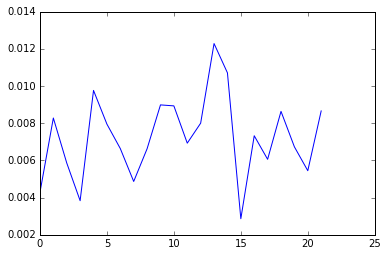

In [45]:
plt.plot(training_error_array)

In [41]:
pred_train2 = TN_utils.predict_original_feature_multiorder(f_output, [tens[:, np.newaxis, :] for tens in input_tensors],
                                            np.array(input_coef)[:, np.newaxis], 10)

In [42]:
pred_train2.shape

(855000, 10)

(array([   1791.,   21340.,   43369.,  109076.,  163562.,  208337.,
         177491.,   98737.,   28004.,    3293.]),
 array([ 0.40381515,  0.50449677,  0.60517838,  0.70585999,  0.80654161,
         0.90722322,  1.00790484,  1.10858645,  1.20926807,  1.30994968,
         1.4106313 ]),
 <a list of 10 Patch objects>)

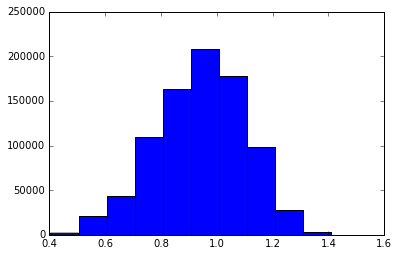

In [46]:
# ちょっと違うな
plt.hist(np.linalg.norm(pred_train2, axis=1))

In [ ]:
nn = models_multi_order.Rcn2layer_multioreder(
        j_input_list=[0, 2, 4], j_output=4, n_input_tensors_list=[1, 1, 1],
        n_hidden_tensors=100, func_key_list=['retanh', 'linear'])

In [ ]:
results = compling_multiorder.compile(
        train_input, train_output[2], test_input, test_output[2],
        model=nn, make_updates=optimizers.adam)
f_train, f_training_error, f_test_error, f_output, param_list = results

In [ ]:
batch_size = 1000
N = train_input[0].shape[0]
n_batchs = N // batch_size
index_list = range(N)
index_list = np.asarray(np.random.permutation(index_list), dtype=np.int32)

N_test = test_input[0].shape[0]
test_index_list = np.asarray(range(N_test), dtype=np.int32)

n_epochs = 51
interval = 10
training_error_array = np.zeros((n_epochs // interval + 2,))
test_error_array = np.zeros((n_epochs // interval + 2,))

alpha = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 10e-8
t = 0.

beta = 0.01

i_batch = 0
training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
training_error_array[0] = training_error
test_error = f_test_error(i_batch, test_index_list, batch_size)[0]
test_error_array[0] = test_error

start_time = time.clock()
for i_epoch in xrange(n_epochs):
    index_list = np.random.permutation(index_list)
    test_index_list = np.random.permutation(test_index_list)

    for i_batch in xrange(n_batchs):
        t = t + 1.
        f_train(i_batch, index_list, batch_size, alpha, beta1, beta2, eps, t, beta, t)
        
    if i_epoch % interval == 0:
        training_error = f_training_error(i_batch, index_list, batch_size, beta, t)[0]
        training_error_array[i_epoch // interval + 1] = training_error
        test_error = f_test_error(0, test_index_list, batch_size)[0]
        test_error_array[i_epoch // interval + 1] = test_error

        alpha = alpha * 0.95
        print i_epoch, training_error, test_error
print time.clock() - start_time

(0, 0.02)

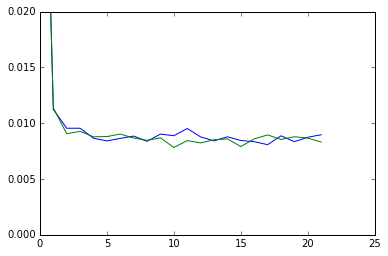

In [345]:
plt.plot(training_error_array)
plt.plot(test_error_array)
plt.ylim(0, 0.02)

In [ ]:
pred_train4 = TN_utils.predict_original_feature_multiorder(f_output, [tens[:, np.newaxis, :] for tens in in_tensor_vec_list],
                                            np.array(input_coef)[:, np.newaxis], 18)

(array([   4346.,   14096.,  136285.,  141062.,   97666.,  130041.,
         204351.,  122055.,    4816.,     282.]),
 array([ 0.58487946,  0.65046296,  0.71604645,  0.78162995,  0.84721345,
         0.91279694,  0.97838044,  1.04396394,  1.10954744,  1.17513093,
         1.24071443]),
 <a list of 10 Patch objects>)

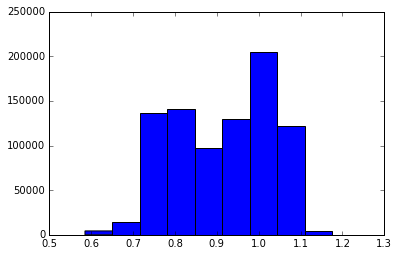

In [346]:
# かなりそれっぽい
plt.hist(np.linalg.norm(pred_train4, axis=1))

In [391]:
def post_process_blind(tens_list, output_coef):
    """
        tens_listのひとつ目の要素はL=2
        output_coefのひとつ目の要素はL=0
    """
    tens0 = np.concatenate([np.ones((tens_list[0].shape[0], 1)), np.zeros((tens_list[0].shape[0], 1))], axis=1)
    tens_list.insert(0, tens0)
    a = [TN_utils.vec2comp(tens) for tens in tens_list]
    return np.concatenate([tens * coef for tens, coef in zip(a, output_coef)], axis=1)

In [392]:
out = post_process([pred_train2, pred_train4], output_coef)

In [394]:
out.shape

(855000, 15)

In [403]:
sio.savemat(proj_path+'results/blind/Aug4/pred.mat', {'pred' : out}) 


In [400]:
pred_train2[0]*output_coef[1]

array([ -4.76330996e-01,   2.01750919e-01,   1.63189638e-02,
         9.51993242e-02,  -4.53426898e-01,   9.70970353e-12,
        -1.63189638e-02,   9.51993242e-02,  -4.76330996e-01,
        -2.01750919e-01], dtype=float32)

In [402]:
pred_train4[0]*output_coef[2]

array([  3.16255301e-01,  -2.38070205e-01,  -4.47670110e-02,
        -7.02758133e-02,   3.02613080e-01,  -6.62047714e-02,
        -3.12356837e-03,  -7.93400556e-02,   2.56312907e-01,
        -1.00344739e-10,   3.12356837e-03,  -7.93400556e-02,
         3.02613080e-01,   6.62047714e-02,   4.47670110e-02,
        -7.02758133e-02,   3.16255301e-01,   2.38070205e-01], dtype=float32)

In [ ]:
tensL0 = [np.concatenate([np.ones((1000, 1, 1)), np.zeros((1000, 1, 1))], axis=1)] # (N, 2, 1)